<a href="https://colab.research.google.com/github/joaocassella/MVP_ML/blob/main/ML_MVP_Notebook_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning - Notebook B
# Professores :
  * Tatiana Escovedo
  * Augusto Baffa
  * Luiz Schirmer

# Aluno : João Cassella

##Definição do Problema
O problema proposto é a classificação de emails entre spam ou não spam, a partir da análise da mensagem.

Foi utilizado o dataset E-Mail classification NLP hospedado em no site kaggle, [Clique aqui](https://www.kaggle.com/datasets/datatattle/email-classification-nlp) para acessar a página do dataset.

O conjunto de dados é composto de 2 datasets, um de treino e outro de testes, ambos no formato csv

##Informações sobre os atributos

O dataset contém 3 atributos descritos a seguir :

* nr - Número da linha
* mensagem - Texto da mensagem do email (corpo do email)
* classe - Classificação (Spam / Non-Spam)


##Importação das bibliotecas



In [1]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dropout,Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from tensorflow.random import set_seed

import nltk
from nltk.corpus import stopwords
from imblearn.over_sampling import RandomOverSampler

nltk.download('stopwords')
stop_words = stopwords.words('english')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Datasets

### Carga Treino e Teste

In [2]:
# Carregando os datasets de treino e teste

treino = pd.read_csv("https://raw.githubusercontent.com/joaocassella/MVP_ML/main/SMS_train.csv", delimiter=',',encoding='latin-1')
teste = pd.read_csv("https://raw.githubusercontent.com/joaocassella/MVP_ML/main/SMS_test.csv", delimiter=',',encoding='latin-1')

print(treino.head())

print(teste.head())


   sn                                           mensagem    classe
0   1                         Rofl. Its true to its name  Non-Spam
1   2  The guy did some bitching but I acted like i'd...  Non-Spam
2   3  Pity, * was in mood for that. So...any other s...  Non-Spam
3   4              Will Ã¼ b going to esplanade fr home?  Non-Spam
4   5  This is the 2nd time we have tried 2 contact u...      Spam
   sn                                           mensagem classe
0   1  UpgrdCentre Orange customer, you may now claim...   Spam
1   2  Loan for any purpose Â£500 - Â£75,000. Homeown...   Spam
2   3  Congrats! Nokia 3650 video camera phone is you...   Spam
3   4  URGENT! Your Mobile number has been awarded wi...   Spam
4   5  Someone has contacted our dating service and e...   Spam


### Informações

In [3]:
# Exibindo as dimensões dos datasets
print("Dataset de treino : ",treino.shape)
print()
print("Dataset de teste : ",teste.shape)

Dataset de treino :  (957, 3)

Dataset de teste :  (125, 3)


In [4]:
# Exibindo as informações dos Datasets
print("Dataset de treino : ",treino.describe())
print()
print("Dataset de teste : ",teste.describe())


Dataset de treino :                 sn
count  957.000000
mean   479.000000
std    276.406404
min      1.000000
25%    240.000000
50%    479.000000
75%    718.000000
max    957.000000

Dataset de teste :                 sn
count  125.000000
mean    63.000000
std     36.228442
min      1.000000
25%     32.000000
50%     63.000000
75%     94.000000
max    125.000000


###Preparação

In [5]:
# Substituindo os valores da coluna classe nos 2 datasets, para 0-1

treino['classe'] = treino['classe'].replace({"Non-Spam": 0, "Spam": 1})
teste['classe'] = teste['classe'].replace({"Non-Spam": 0, "Spam": 1})

print("Dataset de treino : ",treino.head())
print()
print("Dataset de teste : ",teste.head())

Dataset de treino :     sn                                           mensagem  classe
0   1                         Rofl. Its true to its name       0
1   2  The guy did some bitching but I acted like i'd...       0
2   3  Pity, * was in mood for that. So...any other s...       0
3   4              Will Ã¼ b going to esplanade fr home?       0
4   5  This is the 2nd time we have tried 2 contact u...       1

Dataset de teste :     sn                                           mensagem  classe
0   1  UpgrdCentre Orange customer, you may now claim...       1
1   2  Loan for any purpose Â£500 - Â£75,000. Homeown...       1
2   3  Congrats! Nokia 3650 video camera phone is you...       1
3   4  URGENT! Your Mobile number has been awarded wi...       1
4   5  Someone has contacted our dating service and e...       1


In [6]:
# Checando se existem valores nulos
print("Dataset de treino : ",treino.isna().sum())
print()
print("Dataset de teste : ",teste.isna().sum())

Dataset de treino :  sn          0
mensagem    0
classe      0
dtype: int64

Dataset de teste :  sn          0
mensagem    0
classe      0
dtype: int64


In [7]:
# Contando as ocorrências dos domínios 0 e 1 na coluna classe
print("Dataset de treino : ")
print(treino['classe'].value_counts())

print()
print("Dataset de teste : ")
print(teste['classe'].value_counts())

Dataset de treino : 
0    835
1    122
Name: classe, dtype: int64

Dataset de teste : 
1    76
0    49
Name: classe, dtype: int64


### Limpeza dos dados

In [8]:
# Utilizaremos o método stop_words para retirar as palavras que possuem pouco valor semântico e que aparecem com
# frequência nas mensagens tais como : preposições, artigos e conjunções.

STOPWORDS = stopwords.words("english")

In [9]:
# Definindo a função de que fará a normalização dos textos nos datasets :
# 1. Converteremos todos os caracteres para caixa baixa
# 2. Substuiremos alguns termos que não tem valor semântico tais como htts, https, etc
# 3. Aplicaremos o método stop_words carregado acima

def f_limpeza(text):
    text = text.lower()
    text = re.sub("(http|https|www)(:|\.)\S+.com"," ",text)
    text = re.sub("[^\w\d]"," ",text)
    text = " ".join([t for t in text.split() if t not in STOPWORDS])
    return text

# Aplicaremos a função de normalização f_limpeza() tanto no dataset de treino quanto de teste
treino['msg_limpa'] = treino['mensagem'].apply(f_limpeza)

teste['msg_limpa'] = teste['mensagem'].apply(f_limpeza)

treino['msg_limpa'][:5]


0                                       rofl true name
1    guy bitching acted like interested buying some...
2                                pity mood suggestions
3                         ã¼ b going esplanade fr home
4    2nd time tried 2 contact u u â 750 pound prize...
Name: msg_limpa, dtype: object

In [10]:
# Hyperpametros
vocab_size = 5000
max_len = 30

seed = 7
np.random.seed(seed)
set_seed(seed)

In [11]:
# Tokenização e padding

token = Tokenizer(num_words=vocab_size)
token.fit_on_texts(treino['msg_limpa'])

x_train = token.texts_to_sequences(treino['msg_limpa'])

x_test = token.texts_to_sequences(teste['msg_limpa'])

x_test = teste['msg_limpa'].apply(lambda x : f_limpeza(x))
x_test = token.texts_to_sequences(x_test)


x_train = treino['msg_limpa'].apply(lambda x : f_limpeza(x))
x_train = token.texts_to_sequences(x_train)

x_test = pad_sequences(x_test,padding='pre',truncating='pre',maxlen=max_len)
x_train = pad_sequences(x_train,maxlen=max_len,padding='pre',truncating='pre')


# Aplicando oversampling no dataset de treino
ros = RandomOverSampler(random_state=42)
x_train = pad_sequences(x_train,maxlen=max_len,padding='pre',truncating='pre')
x_train_resampled, y_train_resampled = ros.fit_resample(x_train, treino['classe'])



## Criação da Rede Neural


Criaremos uma rede neural sequencial composta por camadas empilhadas, utilizando a biblioteca Keras/TensorFlow.

A arquitetura da rede neural é composta das seguintes camadas :

1. Camada de Embedding: Essa camada recebe como entrada um vetor de palavras e mapeia cada palavra para um vetor denso de tamanho 100. A entrada possui comprimento máximo definido.

2. Camada de Dropout: Essa camada aplica a técnica de regularização e desativa aleatoriamente uma porcentagem dos neurônios durante o treinamento.

3. Camada LSTM: Essa camada é uma camada de Memória de Longo Prazo Recorrente especializada em processar sequências de dados com dependências de longo prazo.

4. Camada de Dropout: Outra camada de Dropout é adicionada após a camada LSTM, com a mesma taxa de dropout da camada anterior.

5. Camada Dense: A camada Dense possui um único neurônio com função de ativação sigmoid, que produz uma saída binária (0 ou 1).

O modelo é compilado com uma função de perda binária_crossentropy, um otimizador Adam e a métrica de precisão para avaliação do desempenho.

####  Inicialização da RN

###Identificação dos melhores Hiperparâmetros

In [12]:
def f_modelo(dropout_rate, lstm_units):
    seed = 7
    np.random.seed(seed)
    set_seed(seed)

    model = Sequential([
        Embedding(vocab_size, 100, input_length=max_len),
        Dropout(dropout_rate),
        LSTM(lstm_units),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

model = KerasClassifier(build_fn=f_modelo)

param_dist = {
    'dropout_rate': uniform(0.2, 0.3),
    'lstm_units': [100, 200, 300]
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, cv=3, n_iter=3)
random_search_result = random_search.fit(x_train, treino['classe'], epochs=5, batch_size=32, validation_data=(x_test, teste['classe']))

print("Melhor Resultado: %f Hiperparâmetros : %s" % (random_search_result.best_score_, random_search_result.best_params_))

Epoch 1/5
20/20 [==============================] - 6s 122ms/step - loss: 0.4169 - acc: 0.8605 - val_loss: 1.1819 - val_acc: 0.3920
Epoch 2/5
20/20 [==============================] - 2s 95ms/step - loss: 0.2021 - acc: 0.9169 - val_loss: 0.3241 - val_acc: 0.8800
Epoch 3/5
20/20 [==============================] - 2s 100ms/step - loss: 0.1209 - acc: 0.9718 - val_loss: 0.6250 - val_acc: 0.7200
Epoch 4/5
20/20 [==============================] - 2s 94ms/step - loss: 0.0430 - acc: 0.9922 - val_loss: 0.2698 - val_acc: 0.8880
Epoch 5/5
10/10 [==============================] - 1s 25ms/step - loss: 0.0733 - acc: 0.9718
Epoch 1/5
20/20 [==============================] - 5s 120ms/step - loss: 0.3659 - acc: 0.8746 - val_loss: 0.9432 - val_acc: 0.3920
Epoch 2/5
20/20 [==============================] - 2s 95ms/step - loss: 0.1975 - acc: 0.9279 - val_loss: 0.9427 - val_acc: 0.5360
Epoch 3/5
20/20 [==============================] - 2s 101ms/step - loss: 0.0781 - acc: 0.9843 - val_loss: 0.3336 - val_acc: 

### Observações sobre os Hiperparâmetros

Executamos diversas rodadas de busca dos hiperparâmetros com diferentes valores de época. Os melhores resultados que obtivemos foram com {'dropout_rate': 0.2260230289519976, 'lstm_units': 300}.


### Treinamento e Teste do Modelo

####Utilização dos Hiperparâmetros Otimizados

In [13]:
# HIPERPARÂMETROS OTIMIZADOS

model = Sequential([
    Embedding(vocab_size, 100, input_length=max_len),
    Dropout(0.2260230289519976),
    LSTM(300),
    Dropout(0.2260230289519976),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

history = model.fit(x_train, treino['classe'], epochs=5, batch_size=32, validation_data=(x_test, teste['classe']))



Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 30, 100)           500000    
                                                                 
 dropout_20 (Dropout)        (None, 30, 100)           0         
                                                                 
 lstm_10 (LSTM)              (None, 300)               481200    
                                                                 
 dropout_21 (Dropout)        (None, 300)               0         
                                                                 
 dense_10 (Dense)            (None, 1)                 301       
                                                                 
Total params: 981,501
Trainable params: 981,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
30/30 [==============================

####Visualização dos Resultados

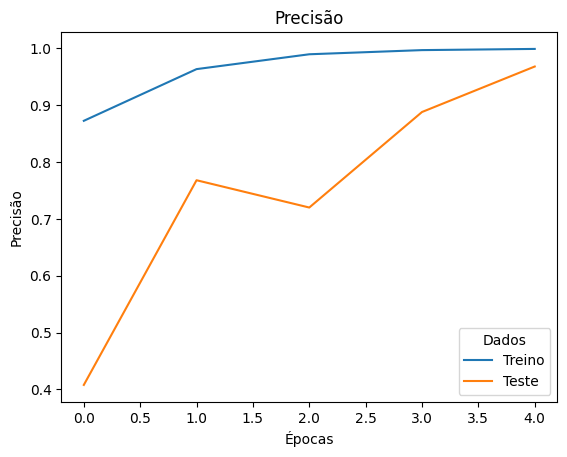

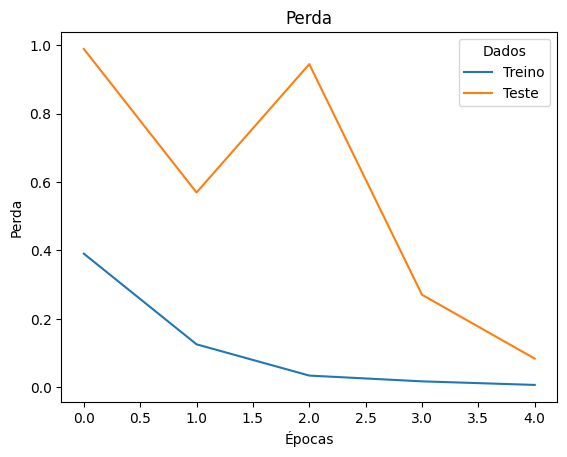

In [14]:
history_df = pd.DataFrame(history.history)
history_df[['acc', 'val_acc']].rename(columns={'acc': 'Treino', 'val_acc': 'Teste'}).plot(title='Precisão')
plt.xlabel('Épocas')
plt.ylabel('Precisão')
plt.legend(title='Dados')
plt.show()

history_df[['loss', 'val_loss']].rename(columns={'loss': 'Treino', 'val_loss': 'Teste'}).plot(title='Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend(title='Dados')
plt.show()


In [15]:
loss,acc = model.evaluate(x_train,treino['classe'])
print()
print ('Resultados do Treino :')
print()
print('Precisão: {:.2f}%'.format(acc * 100))

print()
print('Perda: {:.2f}%'.format(loss * 100))
print('-------------------------------------------------------------------')
loss,acc = model.evaluate(x_test,teste['classe'])
print()
print ('Resultados do Teste :')
print()
print('Precisão: {:.2f}%'.format(acc * 100))

print()
print('Perda: {:.2f}%'.format(loss * 100))

30/30 [==============================] - 1s 38ms/step - loss: 0.0291 - acc: 0.9927

Resultados do Treino :

Precisão: 99.27%

Perda: 2.91%
-------------------------------------------------------------------
4/4 [==============================] - 0s 39ms/step - loss: 0.0836 - acc: 0.9680

Resultados do Teste :

Precisão: 96.80%

Perda: 8.36%


####Salvando o modelo

In [17]:
# salvando o modelo
model.save("Ml_NotebookB.h5")
print("Modelo salvo com sucesso!")

Modelo salvo com sucesso!


### Conclusões Finais
Fizemos diversas rodadas de treino variando a quantidade de épocas. Foi com 5 épocas que obtivemos os melhores resultados.

Observamos que a perda diminui e a precisão aumenta ao longo das épocas no conjunto de treinamento, o que indica que o modelo está aprendendo a partir desse conjunto de dados. O mesmo comportamento observamos no conjunto de  teste, embora em alguns casos possam acontecer flutuações.

Ao final do treinamento, o modelo alcançou uma precisão acima de 90% para o conjunto de teste, o que nos leva a concluir que o modelo está aprendendo a partir dos dados, indicando um bom desempenho na classificação binária.
